In [41]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline


In [42]:
"""数据集加载"""
train_file_path = "../数据/train_data.csv"
train = pd.read_csv(train_file_path)
test_file_path = "../数据/test_data.csv"
test = pd.read_csv(test_file_path)
dev_file_path="../数据/dev_data.csv"
dev=pd.read_csv(dev_file_path)
print("完整训练集大小是 {}".format(train.shape))
print("完整测试集大小是 {}".format(test.shape))
print("完整验证集大小是 {}".format(dev.shape))


完整训练集大小是 (2681, 8)
完整测试集大小是 (575, 8)
完整验证集大小是 (576, 8)


In [43]:
ntrain = train.shape[0]
ntest = test.shape[0]
ndev=dev.shape[0]
y_train = train.SoH.values
dataset_df = pd.concat((train, test,dev)).reset_index(drop=True)
dataset_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print("all_data size is : {}".format(dataset_df.shape))
dataset_df.head(1000)

all_data size is : (3832, 7)


,cycle,capacity,SoH,resistance,CCCT,CVCT,CS_Name
0,1.0,1.126385,0.825175,0.094009,6613.059052,2251.498033,CS2_35
1,2.0,1.126160,0.815965,0.091661,6612.402800,2231.967052,CS2_35
2,3.0,1.125966,0.815977,0.094649,6608.560673,2228.216959,CS2_35
3,4.0,1.118508,0.825194,0.091413,6604.732222,2247.561061,CS2_35
4,5.0,1.117210,0.806900,0.091413,6629.211049,2077.692393,CS2_35
...,...,...,...,...,...,...,...
995,367.0,0.986997,0.724489,0.091462,5643.367621,2353.167577,CS2_36
996,368.0,0.987093,0.724502,0.089925,5649.805783,2336.168251,CS2_36
997,369.0,0.987577,0.724487,0.089925,5653.915617,2333.637176,CS2_36
998,370.0,0.987767,0.724482,0.089925,5661.822564,2314.481645,CS2_36


In [44]:
"""缺失值分析"""
null_per = dataset_df.isnull().sum()
null_per[null_per > 0].sort_values(ascending=False)

CVCT    57
dtype: int64

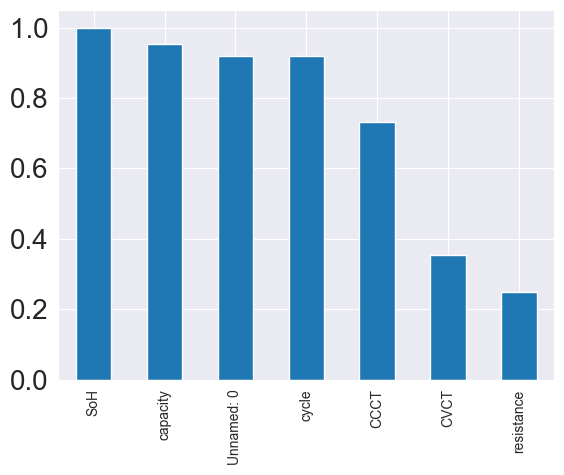

In [45]:
"""相关性分析"""

import matplotlib.pyplot as plt
import pandas as pd

# 选择数值型的列
numeric_train = train.select_dtypes(include=[np.number])

# 计算相关系数
corr_matrix = numeric_train.corr()

# 提取与 SalePrice 列相关的绝对相关系数，并排序
sorted_corr = abs(corr_matrix['SoH']).sort_values(ascending=False)

# 绘制条形图
sorted_corr.plot.bar()
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)

# 显示图形
plt.show()

D:\python\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\python\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\python\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\python\Lib\site-

<Figure size 1200x800 with 0 Axes>

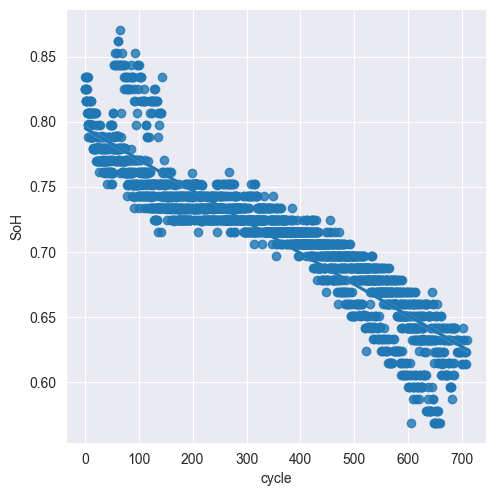

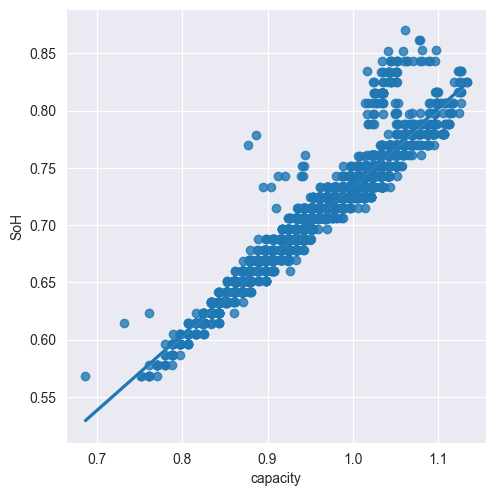

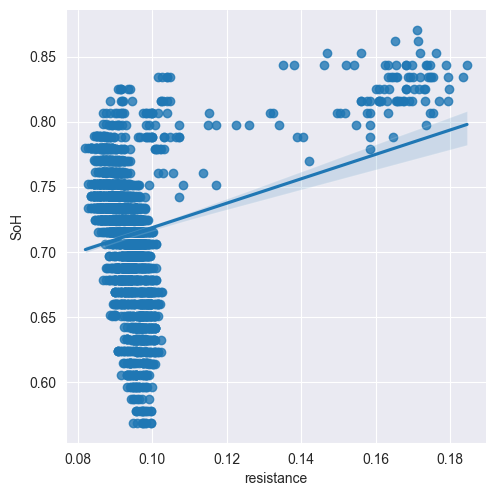

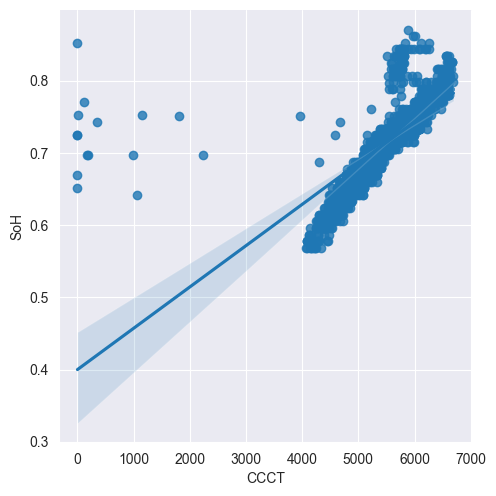

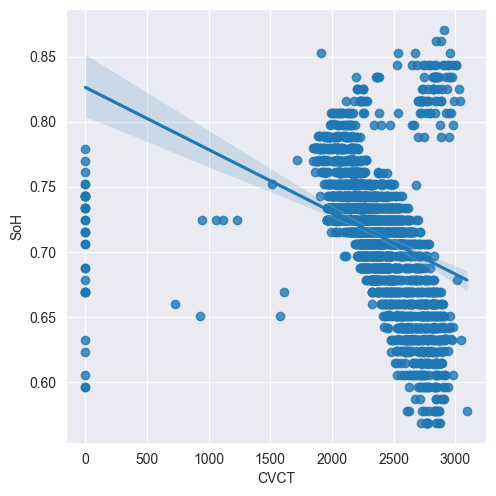

In [46]:
"""异常值分析"""
figure=plt.figure(figsize=(12, 8))
pair_grid1=sns.pairplot(x_vars=['cycle'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")
pair_grid2=sns.pairplot(x_vars=['capacity'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")
pair_grid3=sns.pairplot(x_vars=['resistance'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")
pair_grid4=sns.pairplot(x_vars=['CCCT'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")
pair_grid5=sns.pairplot(x_vars=['CVCT'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")


plt.show()

In [47]:
"""缺失值填充"""
# 计算SoH列的中位数
median_value = dataset_df['CVCT'].median()

# 使用中位数填充SoH列中的缺失值
dataset_df['CVCT'].fillna(median_value, inplace=True)
null_per = dataset_df.isnull().sum()
null_per[null_per > 0].sort_values(ascending=False)
dataset_df.head(100)

C:\Users\钟意\AppData\Local\Temp\ipykernel_19268\3538720298.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_df['CVCT'].fillna(median_value, inplace=True)


,cycle,capacity,SoH,resistance,CCCT,CVCT,CS_Name
0,1.0,1.126385,0.825175,0.094009,6613.059052,2251.498033,CS2_35
1,2.0,1.126160,0.815965,0.091661,6612.402800,2231.967052,CS2_35
2,3.0,1.125966,0.815977,0.094649,6608.560673,2228.216959,CS2_35
3,4.0,1.118508,0.825194,0.091413,6604.732222,2247.561061,CS2_35
4,5.0,1.117210,0.806900,0.091413,6629.211049,2077.692393,CS2_35
...,...,...,...,...,...,...,...
95,96.0,1.016196,0.751706,0.092305,1800.907467,2492.444326,CS2_35
96,97.0,1.015519,0.751713,0.092305,3954.826842,2218.207348,CS2_35
97,98.0,1.014264,0.751727,0.093840,5913.553310,2217.348202,CS2_35
98,99.0,1.022954,0.742641,0.090686,5899.742220,2214.817269,CS2_35


In [48]:

"""异常值清理"""

dataset_df = dataset_df.drop(dataset_df[(dataset_df['CCCT'] < 2000)].index)
dataset_df = dataset_df.drop(dataset_df[(dataset_df['CVCT'] < 1000)].index)
dataset_df = dataset_df.drop(dataset_df[(dataset_df['SoH'] < 0)].index)
dataset_df.to_csv('../数据/清理后的数据/clean_train.csv', index=False)

In [49]:
"""清理测试集"""
clean_test=test.drop(test[(test['SoH'] > 0)].index)

def rolling_window_avg(series, window_size=2):
    return series.rolling(window=window_size * 2 + 1, min_periods=1, center=True).mean()

# 应用这个函数到CVCT列
clean_test['CVCT_rolling_avg'] = rolling_window_avg(dataset_df['CVCT'])
clean_test['CCCT_rolling_avg'] = rolling_window_avg(dataset_df['CCCT'])
# 现在，我们有了一个新的列CVCT_rolling_avg，它包含了每个数据点的前五个和后五个数据的平均值
# 接下来，我们用这个新列来填充原始CVCT列的缺失值
clean_test['CVCT'] = dataset_df.apply(lambda row: row['CVCT_rolling_avg'] if pd.isna(row['CVCT']) else row['CVCT'], axis=1)
clean_test['CCCT'] = dataset_df.apply(lambda row: row['CCCT_rolling_avg'] if pd.isna(row['CCCT']) else row['CCCT'], axis=1)

clean_test.drop(['CVCT_rolling_avg'], axis=1, inplace=True)
clean_test.drop(['CCCT_rolling_avg'], axis=1, inplace=True)
clean_test.drop(['Un'], axis=1, inplace=True)
clean_test.to_csv('../数据/清理后的数据/clean_test.csv', index=False)


PermissionError: [Errno 13] Permission denied: '../数据/清理后的数据/clean_test.csv'